<a href="https://colab.research.google.com/github/mona-baharlou/FastAI_RabbitOrNot/blob/main/Is_it_a_rabbit%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it a Rabbit?

## Step 1: Download images of rabbits and non-rabbits

In [ ]:
!pip install duckduckgo-search

from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [ ]:
urls = search_images('rabbit photos', max_images=1)
urls[0]

/tmp/ipython-input-2195883467.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


'https://images.unsplash.com/photo-1516632664305-eda5d6a5bb99?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=1080&fit=max&ixid=eyJhcHBfaWQiOjEyMDd9'

...and then download a URL and take a look at it:

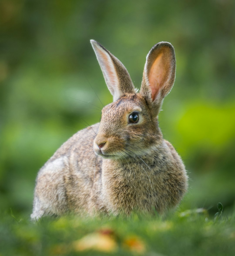

In [ ]:
#Visualizing the image:
from fastdownload import download_url
dest = 'rabbit.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

/tmp/ipython-input-2195883467.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


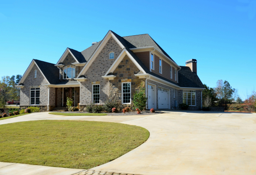

In [ ]:
download_url(search_images('house photos', max_images=1)[0], 'house.jpg', show_progress=False)
Image.open('house.jpg').to_thumb(256,256)

In [ ]:
# Building the Dataset
from pathlib import Path
from fastai.vision.utils import download_images, resize_images

# labels
searches = 'house','rabbit'
# sets the root directory for the dataset to a folder named rabbit_or_not.
path = Path('rabbit_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    #  to avoid overwhelming servers and getting blocked
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/tmp/ipython-input-2195883467.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b34607f78c0>
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b3460578360>
  self.pid = os.fork()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveI

In [ ]:
# verify_images: checks the integrity of the downloaded images. It identifies any files that are corrupt or unreadable.
# get_image_files: returns a list of all image files in the path directory.
failed = verify_images(get_image_files(path))
#  takes the list of failed images and uses the unlink method to delete them from the file system
failed.map(Path.unlink)
# number of failed images
len(failed)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b34607f78c0>
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b3460578360>
  self.pid = os.fork()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() n

1

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

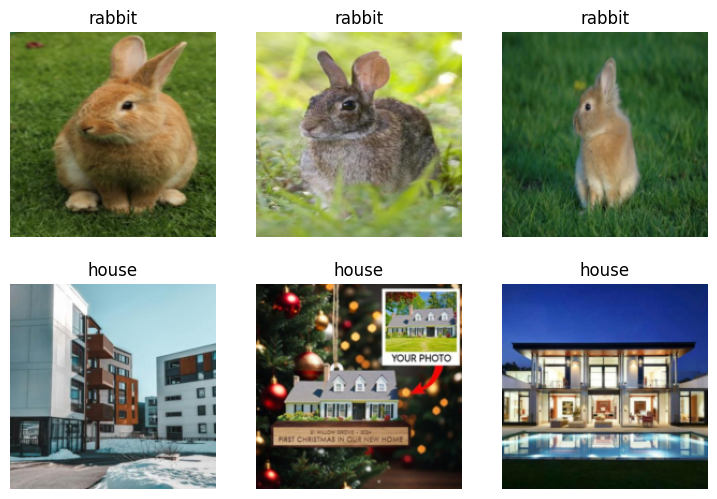

In [ ]:
#  DataBlock(): how to get data and prepare it for a machine learning model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Specifies that the input data is an image and the output is a category
    get_items=get_image_files, # the function to use to find the files
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # splits the dataset into a training set and a validation set. seed=42 ensures the split is reproducible
    get_y=parent_label, # automatically infers the label of an image from the name of its parent folder
    item_tfms=[Resize(192, method='squish')] # applies transformations to each image. It resizes every image to 192x192 pixels, using the 'squish' method to force the image into the new dimensions.
).dataloaders(path, bs=32) #  is responsible for loading the data in batches during training. bs=32 means the model will be trained on batches of 32 images at a time.

#  displays a small batch of images and their labels, providing a final check to ensure the data is loaded correctly before training
dls.show_batch(max_n=6)

In [ ]:
# Model Training

# vision_learner: the central class in fastai for training
learn = vision_learner(dls, resnet18, metrics=error_rate)
#  start the training process
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.369051,0.057613,0.020270,00:03


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b34607f78c0>
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b3460578360>
  self.pid = os.fork()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed soc

epoch,train_loss,valid_loss,error_rate,time
0,0.050011,0.043987,0.013514,00:03
1,0.041516,0.006776,0.000000,00:02
2,0.031771,0.000271,0.000000,00:02


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b34607f78c0>
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b3460578360>
  self.pid = os.fork()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed soc

## Step 3: Use our model (and build your own!)

In [ ]:
# PILImage(): loads the rabbit.jpg image that was downloaded in the very first step.
# .predict(): uses the trained model to make a prediction on the new image
is_rabbit,_,probs = learn.predict(PILImage.create('rabbit.jpg'))
rabbit_index = learn.dls.vocab.o2i['rabbit']

print(f"This is a: {is_rabbit}.")
print(f"Probability it's a rabbit: {probs[rabbit_index]:.4f}")

This is a: rabbit.
Probability it's a rabbit: 1.0000
